# Partielle differensialligninger

## Nøyaktighetsanalyse vha. «konstruert løsning»

Velg en passende løsning, f.eks.
$$
u(x, t) = t^2 + 4 x^3.
$$
Denne har
$$
\frac{\partial u}{\partial t} = 2t, \quad \frac{\partial^2 u}{\partial x^2} = 24 x
$$
og tilfredsstiller dermed differensialligningen
$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + 2 t - 24 x
$$
som til forveksling ligner diffusjonsligningen.

Initialbetingelse:
$$
u(x, 0) = 4 x^3
$$
Dirichlet randbetingelser:
$$
u(0, t) = t^2, \quad u(1, t) = t^2 + 4
$$

Eksplisitt skjema:
$$
\begin{aligned}
\frac{u^{n + 1}_i - u^n_i}{\Delta t} &= \frac{u^n_{i + 1} - 2 u^n_i + u^n_{i - 1}}{\Delta x^2} + 2 t^n - 24 x_i \\
\Rightarrow \quad
u^{n + 1}_i &= u^n_i + \alpha(u^n_{i + 1} - 2 u^n_i + u^n_{i - 1}) + \Delta t (2 t^n - 24 x_i)
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def konstruert(N_punkter, N_tider):
    delta_t = 1 / (N_tider - 1)
    delta_x = 1 / (N_punkter - 1)
    alpha = delta_t / delta_x**2
    x = np.linspace(0, 1, N_punkter)
    u = 4 * x**3
    for n in range(N_tider - 1):
        t = delta_t * (n + 1)
        u[1:-1] += alpha * (u[2:] - 2 * u[1:-1] + u[:-2]) + delta_t * (2 * t - 24 * x[1:-1])
        u[0] = t**2
        u[-1] = t**2 + 4
    return x, u

def eksakt(x):
    return 1 + 4 * x**3

def feil(N_punkter, N_tider):
    x, u = konstruert(N_punkter, N_tider)
    u_e = eksakt(x)
    return np.sum(np.abs(u - u_e)) / N_punkter

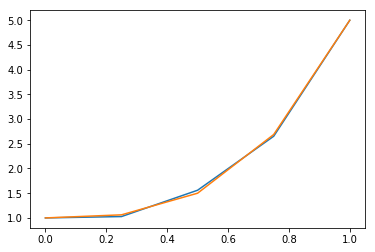

In [2]:
x, u = konstruert(5, 25)
plt.plot(x, u)
plt.plot(x, eksakt(x))

Analyse av feil som funksjon av tidsskritt

In [3]:
n_punkter = 5
for n_tider in np.arange(50, 250, 50):
    E = feil(n_punkter, n_tider)
    print("%d\t%f\t%f\t%f" % (n_tider, E, E * n_tider, E * n_tider**2))

50	0.001275	0.063774	3.188679
100	0.000631	0.063128	6.312799
150	0.000419	0.062916	9.437333
200	0.000314	0.062810	12.561968


Feilen er altså proprosjonal med $\Delta t$.

Analyse av feil som funksjon av romlig diskretisering:

In [4]:
n_tider = 200
for n_punkter in np.arange(2, 10):
    E = feil(n_punkter, n_tider)
    print("%d\t%f" % (n_punkter, E))

2	0.000000
3	0.000209
4	0.000279
5	0.000314
6	0.000335
7	0.000349
8	0.000359
9	0.000366


!!!

## Implisitt metode

Sett opp system for tridiagonal matrise og overlat jobben til Python

In [5]:
import matplotlib.animation
from IPython.display import HTML
from scipy.sparse import spdiags

# Parametre

N_punkter = 50
N_tider = 10
alpha = 10      # k * dt / dx**2

# Initialiser

x = np.linspace(0, 1, N_punkter)
T = np.ones((N_tider, N_punkter))
T[:, N_punkter // 2:] = 0

# Systemmatrisen

upperdiag = np.concatenate(([0, 0], -alpha * np.ones(N_punkter - 2)))
centerdiag = np.concatenate(([1], (1 + 2 * alpha) * np.ones(N_punkter - 2),
                             [1]))
lowerdiag = np.concatenate((-alpha * np.ones(N_punkter - 2), [0, 0]))
diags = np.array([upperdiag, centerdiag, lowerdiag])
A = spdiags(diags, [1, 0, -1], N_punkter, N_punkter).todense()

# Løs diffusjonsligningen

for n in range(N_tider - 1):
    T[n + 1, :] = np.linalg.solve(A, T[n, :])

# Sett opp for animasjon

fig, ax = plt.subplots()
ax.axis([0, 1, 0, 1])
l, = ax.plot([],[])
plt.close()

# Animasjonsfunksjonen

def animate(n):
    l.set_data(x, T[n, :])

# Snurr film!

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=N_tider)
HTML(ani.to_jshtml())

## 2D diffusjonsligning

$$
\frac{\partial u}{\partial t} = \nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
$$
Eksplisitt tidsintegrasjon:
$$
\frac{u^{n + 1}_{i,j} - u^n_{i,j}}{\Delta t} = \frac1{\Delta x^2}(u^n_{i + 1,j} + u^n_{i - 1,j} + u^n_{i,j + 1} + u^n_{i,j - 1} - 4 u^n_{i,j})
$$

### For temperaturutbredelse i rom

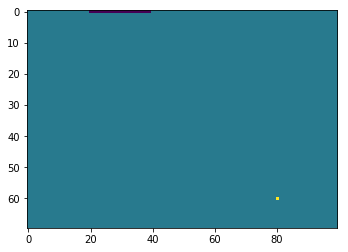

In [6]:
# Sett opp og vis initiell tempeturprofil

T = 21 * np.ones((70, 100))
T[0, 20:40] = 8
T[-10, -20] = 40
plt.imshow(T)

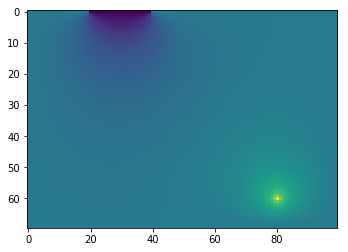

In [7]:
# Løs diffusjonsligningen

alpha = .25
for i in range(10000):
    T[1:-1, 1:-1] += alpha * (T[:-2, 1:-1] +
                              T[2:, 1:-1] +
                              T[1:-1, :-2] +
                              T[1:-1, 2:] -
                              4 * T[1:-1, 1:-1])
    T[-10, -20] = 40

plt.imshow(T)

### For støyfjerning i bilder

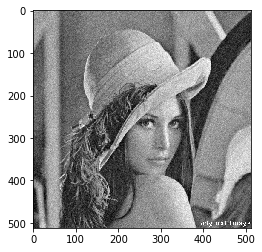

In [8]:
import imageio

# Les bildet og legg til støy

im = imageio.imread('lena.png')
im = np.sum(im.astype(float), 2) / (3 * 255)
im = im + .05 * np.random.randn(*np.shape(im))
im[im < 0] = 0
im[im > 1] = 1

# Vis

plt.imshow(im, plt.cm.gray)

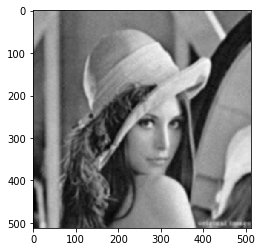

In [9]:
# Løs diffusjonsligningen

alpha = .25                     # dt / dx**2
for i in range(10):
    laplace = (im[0:-2, 1:-1] +
               im[2:, 1:-1] +
               im[1:-1, 0:-2] +
               im[1:-1, 2:] -
               4 * im[1:-1, 1:-1])
    im[1:-1, 1:-1] += alpha * laplace
    im[:, 0] = im[:, 1]      # Neumann randbetingelse
    im[:, -1] = im[:, -2]    #
    im[0, :] = im[1, :]      #
    im[-1, :] = im[-2 , :]   #

plt.imshow(im, plt.cm.gray)

For fargebilder blir det et system av PDE-er; én for hver fargekanal

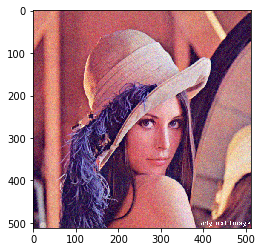

In [10]:
im = imageio.imread('lena.png')
im = im.astype(float) / 255
im = im + .05 * np.random.randn(*np.shape(im))
im[im < 0] = 0
im[im > 1] = 1

# Vis

plt.imshow(im)

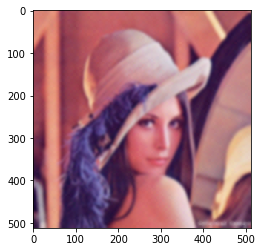

In [11]:
# Løs diffusjonsligningen (på nøyaktig samme vis!!!)

alpha = .25                     # dt / dx**2
for i in range(20):
    laplace = (im[0:-2, 1:-1] +
               im[2:, 1:-1] +
               im[1:-1, 0:-2] +
               im[1:-1, 2:] -
               4 * im[1:-1, 1:-1])
    im[1:-1, 1:-1] += alpha * laplace
    im[:, 0] = im[:, 1]      # Neumann randbetingelse
    im[:, -1] = im[:, -2]    #
    im[0, :] = im[1, :]      #
    im[-1, :] = im[-2 , :]   #

plt.imshow(im)